# Neutrino Survival Probability

In this notebook, we calculate the survival probability of a reactor electron antineutrino at given energy $E_{\nu}$ and baseline $L$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.dpi": 600,
        "font.family": "serif",
        "font.size": 15,
        # 'figure.dpi': 300,
        "lines.linewidth": 2.0,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 8,
        "xtick.minor.size": 4,
        "ytick.major.size": 8,
        "ytick.minor.size": 4,
        "xtick.major.width": 1,
        "xtick.minor.width": 0.7,
        "ytick.major.width": 1,
        "ytick.minor.width": 0.7,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "legend.loc": "upper center",
        "legend.fancybox": True,  # if True, use a rounded box for the
        # legend background, else a rectangle
        "legend.fontsize": 15,
        "text.usetex": True,
    }
)

The mixing angles and mass differences are taken from [PDG 2020](https://doi.org/10.1093/ptep/ptaa104)

In [2]:
s_theta_12_squared = 0.307
s_theta_13_squared = 0.0218
s_theta_23_squared = [0.545, 0.547]  # normal and inverted hierarchy
delta_cp = 1.36  # radians
delta_m21_squared = 7.53e-5  # eV^2
delta_m32_squared = [2.453e-3, -2.546e-3]  # eV^2, normal and inverted hierarchy

Considering matter effect (MSW)

The matter potential $A$, is given by:

$$
A = 2\sqrt{2} G_F N_e E = 2\sqrt{2} G_F Y_e \rho N_A E \approx 1.52 \times 10^{-4} \text{eV}^2 \cdot Y_e \cdot \frac{\rho}{\text{g}/\text{cm}^3} \cdot \frac{E}{\text{GeV}}
$$

In [3]:
G_F = 1.1663787e-5  # GeV^-2
Y_e = 0.5  # electron fraction in matter
rho = 2.45  # g/cm^3, average Earth crust density
# rho = 0 # Let's set matter density to zero for vacuum oscillations
N_A = scipy.constants.Avogadro  # Avogadro's number
hbar_c = scipy.constants.hbar * scipy.constants.c / scipy.constants.e * 1e-7  # GeV*cm


def matter_potential(E_nu):
    """Calculate the matter potential A for neutrinos in matter.

    Parameters:
    ----------
    E_nu : float
        Neutrino energy in MeV.

    Returns:
    -------
    A : float
        Matter potential in eV^2.
    """
    N_e = Y_e * rho * N_A  # electron number density in cm^-3
    N_e_natural = N_e * (hbar_c) ** 3  # convert to natural units (GeV^3)
    A = 2 * np.sqrt(2) * G_F * N_e_natural * E_nu * 1e-3 * 1e18  # eV^2
    return A

Next, the effective mixing angles and mass differences are calculated with the following analytical formulas:

$$
\cos (2\tilde{\theta}_{13}) = \frac{\cos (2\theta_{13}) - \hat{A}_{13}}{\sqrt{\left(\cos (2\theta_{13}) - \hat{A}_{13}\right)^2 + \sin^2 (2\theta_{13})}}
$$

$$
\cos (2\tilde{\theta}_{12}) = \frac{\cos (2\theta_{12}) - \hat{A}_{12}}{\sqrt{\left(\cos (2\theta_{12}) - \hat{A}_{12}\right)^2 + \sin^2 (2\theta_{12})}}
$$

$$
\Delta \tilde{m}_{31}^2 = \Delta m_{31}^2 \sqrt{\left(\cos (2\theta_{13}) - \hat{A}_{13}\right)^2 + \sin^2 (2\theta_{13})}
$$

$$
\Delta \tilde{m}_{21}^2 = \Delta m_{21}^2 \sqrt{\left(\cos (2\theta_{12}) - \hat{A}_{12}\right)^2 + \sin^2 (2\theta_{12})}
$$

where $\hat{A}_{13} \equiv \frac{A}{\Delta m_{31}^2}$, $\hat{A}_{12} \equiv \frac{A \cos^2 \theta_{13}}{\Delta m_{21}^2}$. Note that for antineutrinos we need to flip the sign of the matter potential.

In [4]:
def effective_parameters(E_nu, neutrino="antineutrino", hierarchy="normal"):
    """Calculate the effective mixing angles and mass-squared differences in matter.

    Parameters:
    ----------
    E_nu : float
        Neutrino energy in MeV.
    neutrino : str
        'neutrino' or 'antineutrino'.
    hierarchy : str
        'normal' or 'inverted' mass hierarchy.

    Returns:
    -------
    s_theta_12_squared_m : float
        Effective sin^2(theta_12) in matter.
    s_theta_13_squared_m : float
        Effective sin^2(theta_13) in matter.
    delta_m21_squared_m : float
        Effective delta m^2_21 in matter (eV^2).
    delta_m31_squared_m : float
        Effective delta m^2_31 in matter (eV^2).
    """
    A = matter_potential(E_nu)
    delta_m31_squared = (
        delta_m32_squared[0] + delta_m21_squared
        if hierarchy == "normal"
        else delta_m32_squared[1] + delta_m21_squared
    )
    assert neutrino in [
        "neutrino",
        "antineutrino",
    ], "neutrino must be 'neutrino' or 'antineutrino'"
    if neutrino == "antineutrino":
        # For antineutrinos, the matter potential changes sign
        A = -A
    A_tilde_13 = A / delta_m31_squared  # dimensionless matter potential for 1-3 sector
    A_tilde_12 = (
        A * (1 - s_theta_13_squared) / delta_m21_squared
    )  # dimensionless matter potential for 1-2 sector

    # Calculate effective parameters, using approximate analytical formulas
    # Full calculation would involve diagonalizing the Hamiltonian in matter
    s_double_theta_13_squared = 4 * s_theta_13_squared * (1 - s_theta_13_squared)
    c_double_theta_13_m = (1 - 2 * s_theta_13_squared - A_tilde_13) / np.sqrt(
        A_tilde_13**2 - 2 * A_tilde_13 * (1 - 2 * s_theta_13_squared) + 1
    )
    s_theta_13_squared_m = 0.5 * (1 - c_double_theta_13_m)
    delta_m31_squared_m = delta_m31_squared * np.sqrt(
        A_tilde_13**2 - 2 * A_tilde_13 * (1 - 2 * s_theta_13_squared) + 1
    )

    s_double_theta_12_squared = 4 * s_theta_12_squared * (1 - s_theta_12_squared)
    c_double_theta_12_m = (1 - 2 * s_theta_12_squared - A_tilde_12) / np.sqrt(
        A_tilde_12**2 - 2 * A_tilde_12 * (1 - 2 * s_theta_12_squared) + 1
    )
    s_theta_12_squared_m = 0.5 * (1 - c_double_theta_12_m)
    delta_m21_squared_m = delta_m21_squared * np.sqrt(
        A_tilde_12**2 - 2 * A_tilde_12 * (1 - 2 * s_theta_12_squared) + 1
    )

    return (
        s_theta_12_squared_m,
        s_theta_13_squared_m,
        delta_m21_squared_m,
        delta_m31_squared_m,
    )

Calculate the electron antineutrino survival probability

In [5]:
def survival_probability(E_nu, L, hierarchy="normal"):
    """Calculate the electron antineutrino survival probability in matter.

    Parameters:
    ----------
    E_nu : float
        Neutrino energy in MeV.
    L : float
        Baseline distance in km.
    hierarchy : str
        'normal' or 'inverted' mass hierarchy.

    Returns:
    -------
    P_ee : float
        Electron antineutrino survival probability.
    """
    # Effective parameters in matter
    (
        s_theta_12_squared_m,
        s_theta_13_squared_m,
        delta_m21_squared_m,
        delta_m31_squared_m,
    ) = effective_parameters(E_nu, neutrino="antineutrino", hierarchy=hierarchy)
    c_theta_12_squared_m = 1 - s_theta_12_squared_m
    c_theta_13_squared_m = 1 - s_theta_13_squared_m
    s_double_theta_12_squared_m = 4 * s_theta_12_squared_m * (1 - s_theta_12_squared_m)
    s_double_theta_13_squared_m = 4 * s_theta_13_squared_m * (1 - s_theta_13_squared_m)
    delta_m32_squared_m = delta_m31_squared_m - delta_m21_squared_m

    # Calculate oscillation phases
    delta_21 = delta_m21_squared_m * L / (4 * E_nu) / hbar_c * 1e-10  # in radians
    delta_31 = delta_m31_squared_m * L / (4 * E_nu) / hbar_c * 1e-10  # in radians
    delta_32 = delta_m32_squared_m * L / (4 * E_nu) / hbar_c * 1e-10  # in radians

    # Survival probability formula
    P_ee = (
        1
        - s_double_theta_12_squared_m * c_theta_13_squared_m**2 * np.sin(delta_21) ** 2
        - s_double_theta_13_squared_m
        * (
            c_theta_12_squared_m * np.sin(delta_31) ** 2
            + s_theta_12_squared_m * np.sin(delta_32) ** 2
        )
    )

    return P_ee

Now, we calculate the oscillation probability at JUNO baseline. This should reproduce the results of Fig. 1 (bottom), Angel Abusleme et al 2025 Chinese Phys.C 49 033104

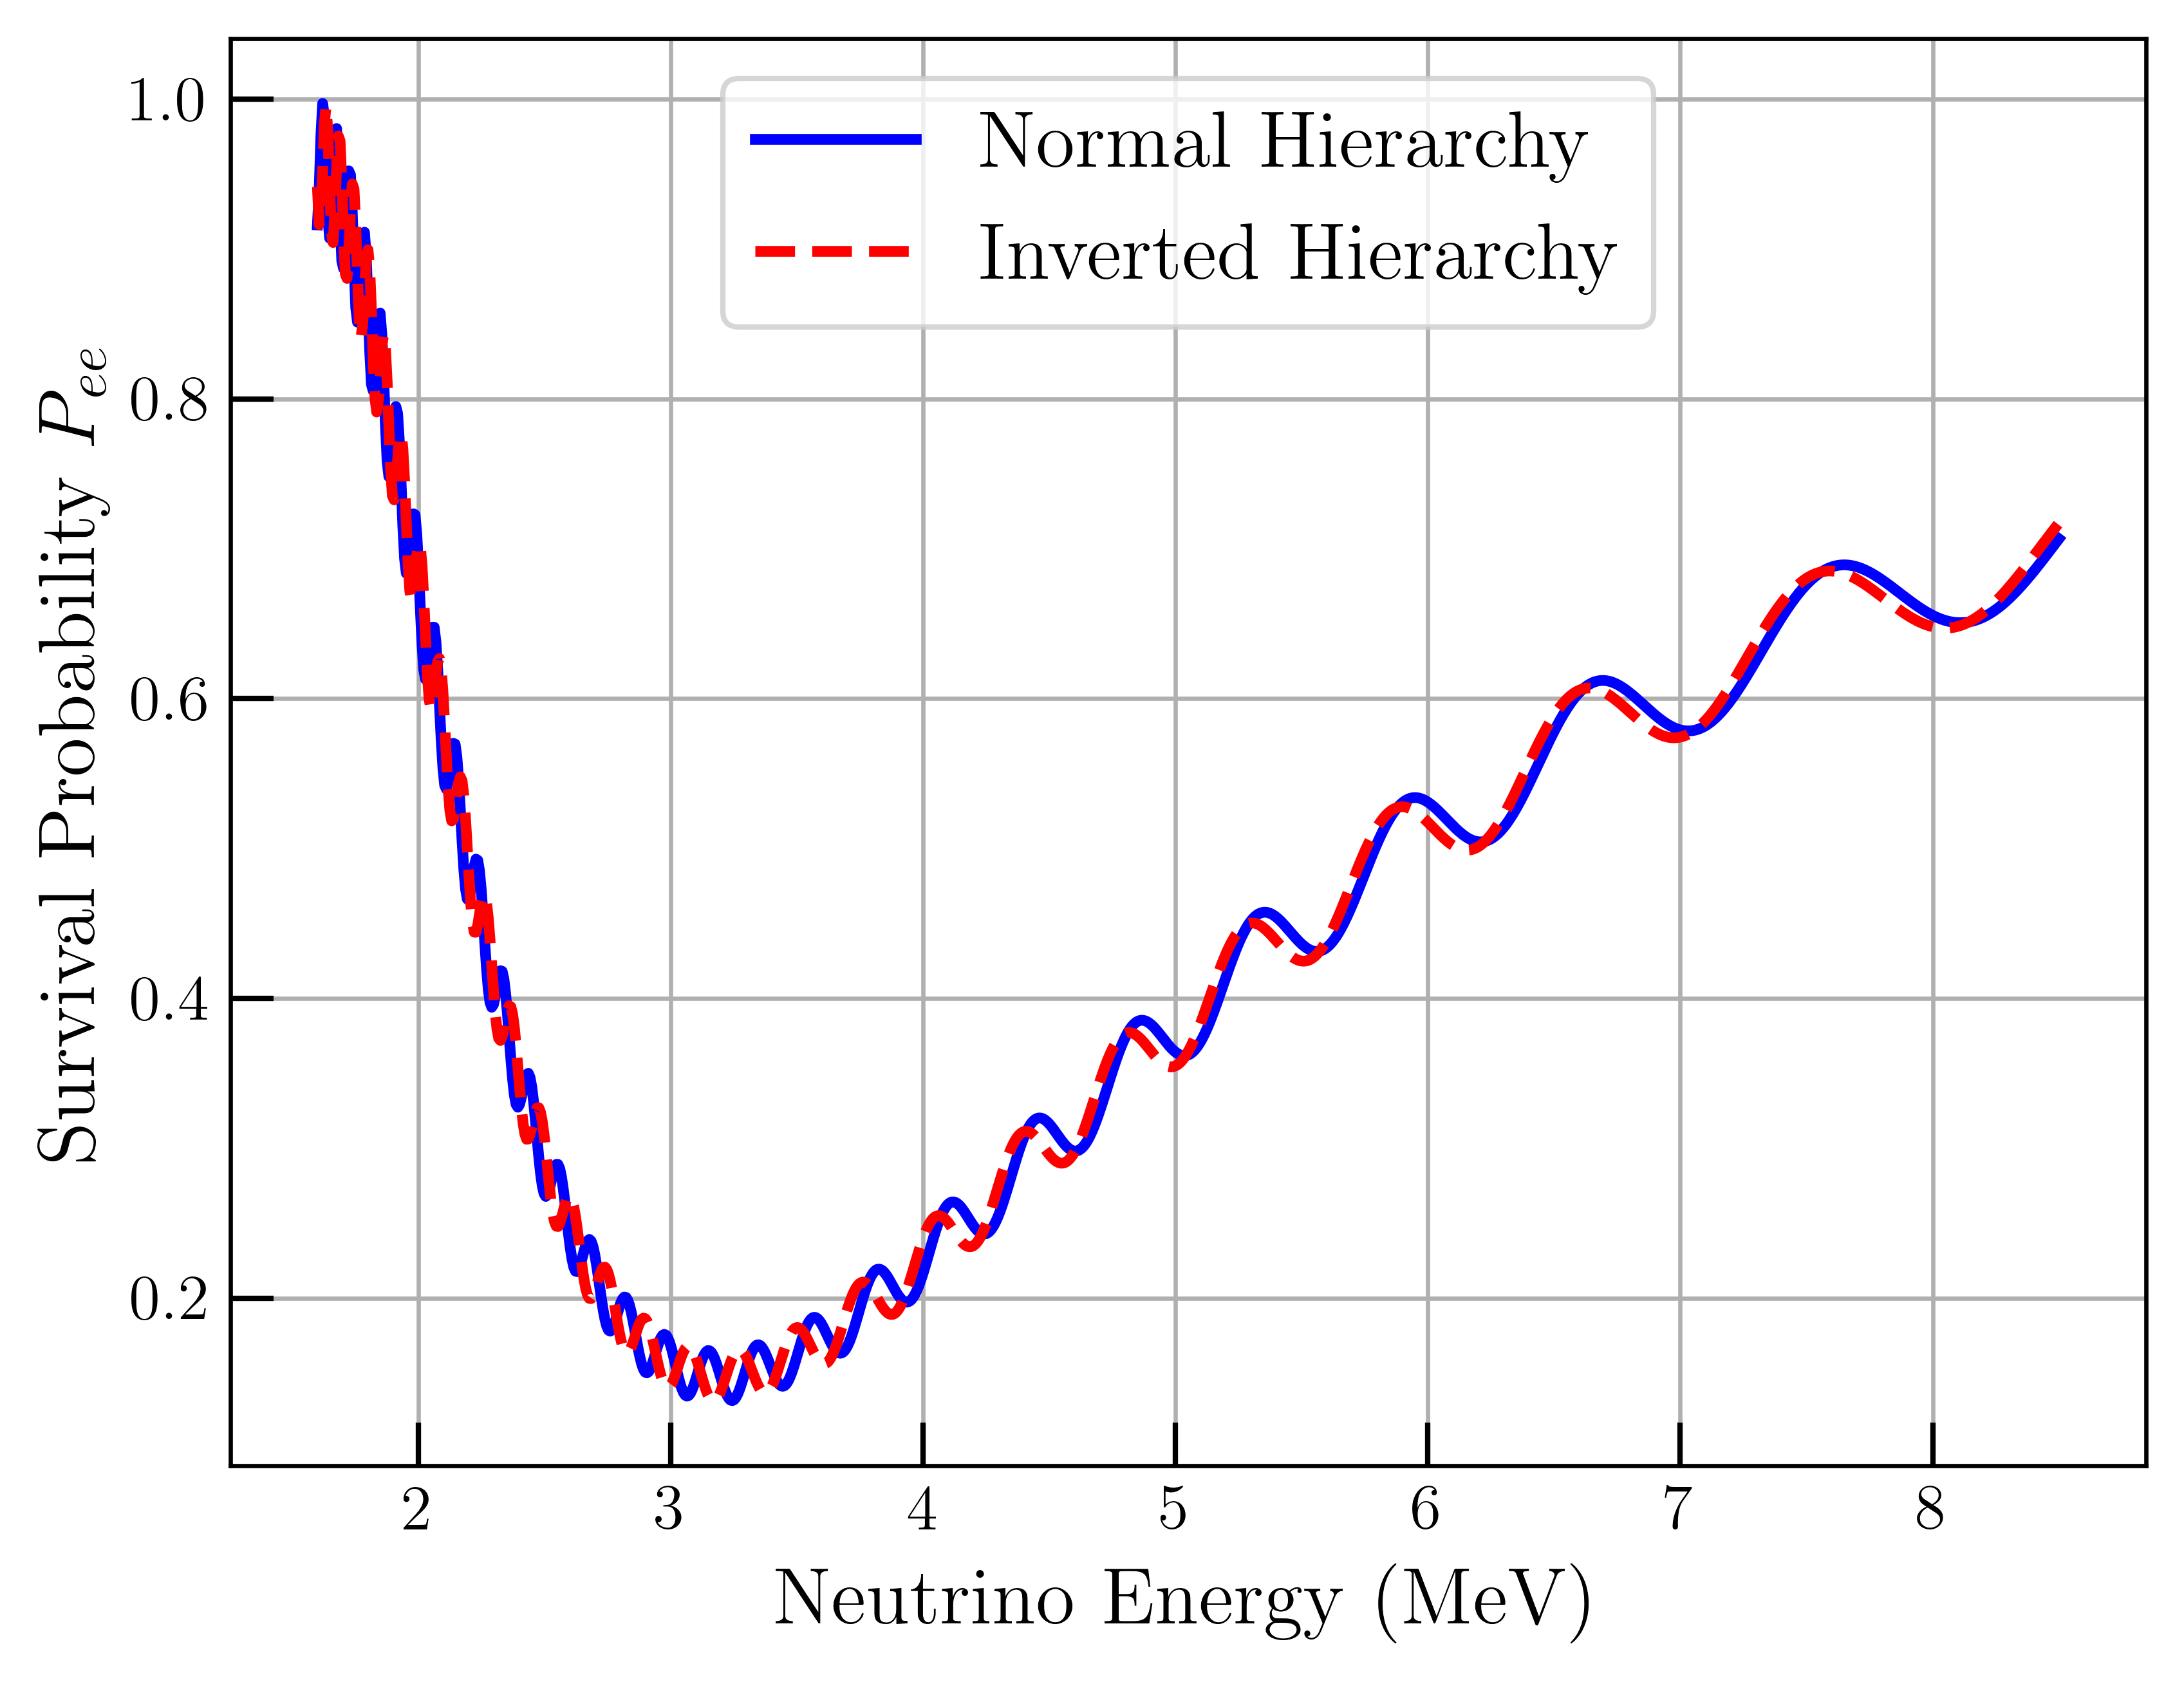

In [6]:
energies = np.linspace(1.6, 8.5, 1000)  # MeV
baseline = 52.5  # km, JUNO baseline
P_ee_normal = survival_probability(energies, baseline, hierarchy="normal")
P_ee_inverted = survival_probability(energies, baseline, hierarchy="inverted")

# plt.figure(figsize=(10, 3))
plt.plot(energies, P_ee_normal, label="Normal Hierarchy", color="blue")
plt.plot(
    energies, P_ee_inverted, label="Inverted Hierarchy", color="red", linestyle="--"
)
# plt.title("Electron Antineutrino Survival Probability at JUNO Baseline")
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Survival Probability $P_{ee}$")
plt.legend()
plt.grid()
plt.savefig("./plots/neutrino_survival_probability_juno.pdf", bbox_inches="tight")

Let's put them together. It is interesting to see how the MSW effect changes the survival probability:

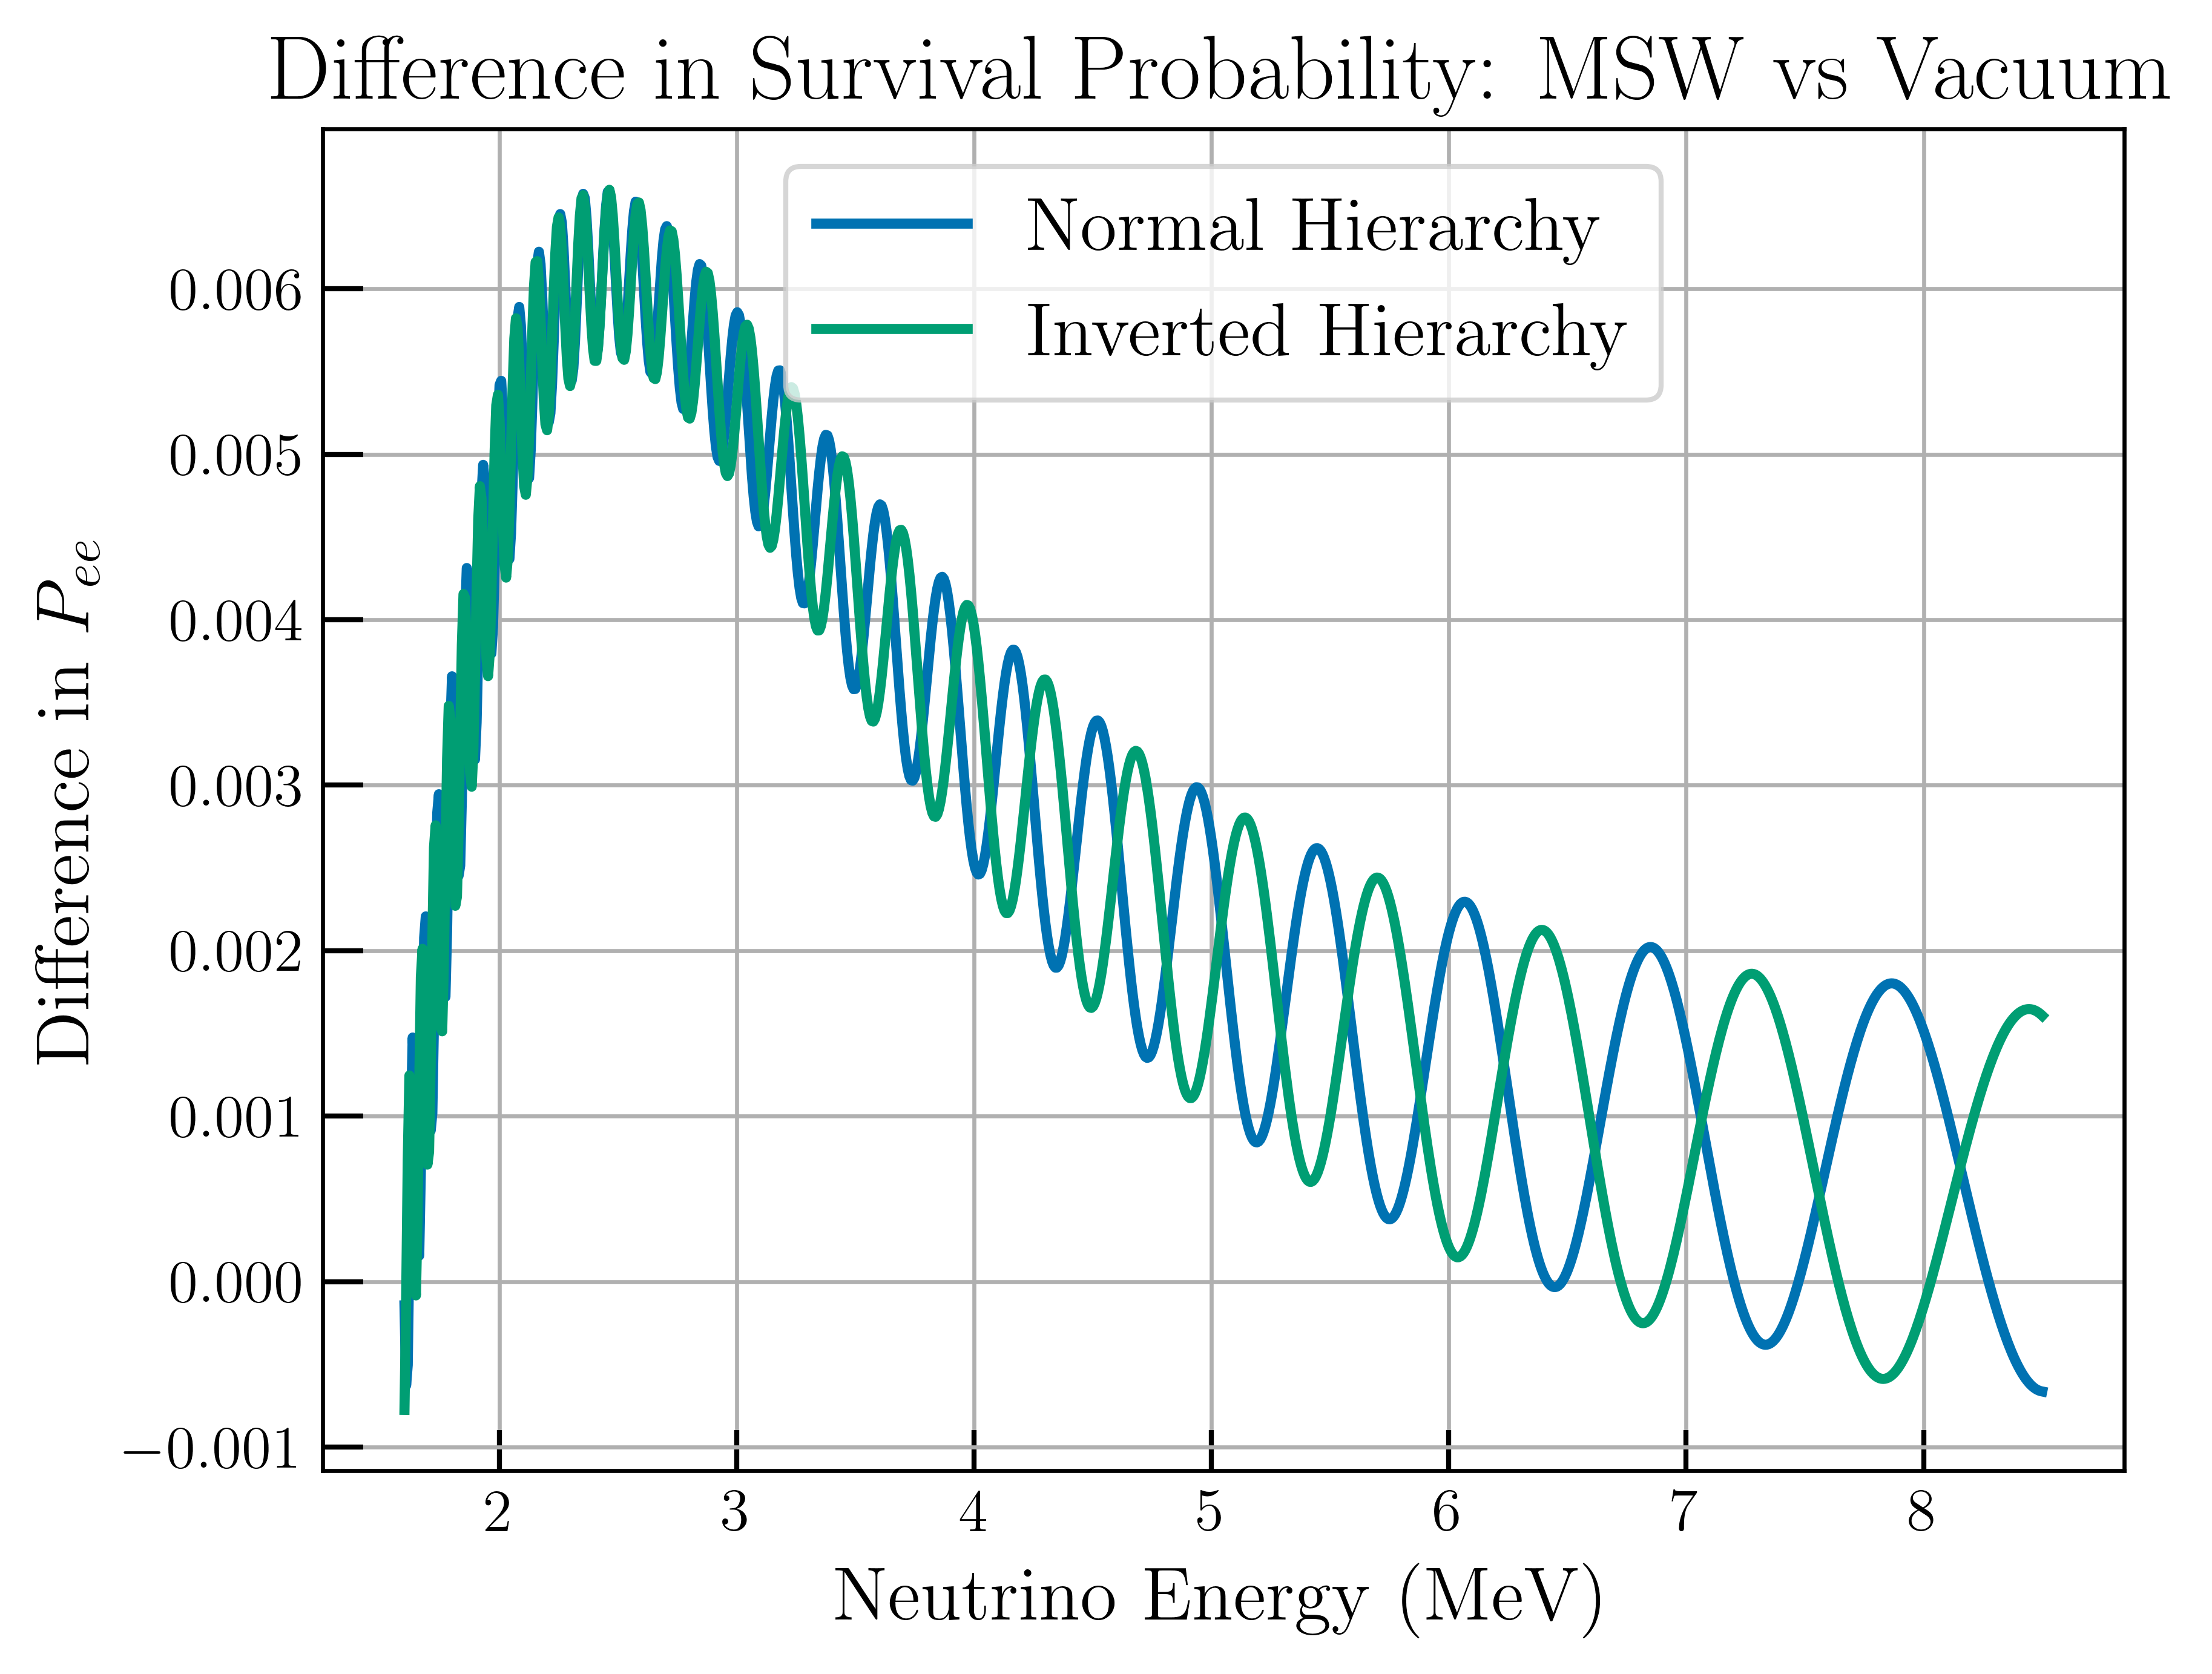

In [7]:
from neutrino_survival import NeutrinoSurvival

ns_msw = NeutrinoSurvival()
P_ee_normal_cls = ns_msw.survival_probability(energies, baseline, hierarchy="normal")
P_ee_inverted_cls = ns_msw.survival_probability(
    energies, baseline, hierarchy="inverted"
)

ns_vacuum = NeutrinoSurvival(rho=0)
P_ee_normal_vacuum = ns_vacuum.survival_probability(
    energies, baseline, hierarchy="normal"
)
P_ee_inverted_vacuum = ns_vacuum.survival_probability(
    energies, baseline, hierarchy="inverted"
)

plt.plot(energies, P_ee_normal_cls - P_ee_normal_vacuum, label="Normal Hierarchy")
plt.plot(energies, P_ee_inverted_cls - P_ee_inverted_vacuum, label="Inverted Hierarchy")
plt.title("Difference in Survival Probability: MSW vs Vacuum")
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Difference in $P_{ee}$")
plt.legend()
plt.grid()
plt.show()

Alternatively, we use the more systematic approach of Denton-Minakata-Parke (DMP), arxiv:1604.08167v1

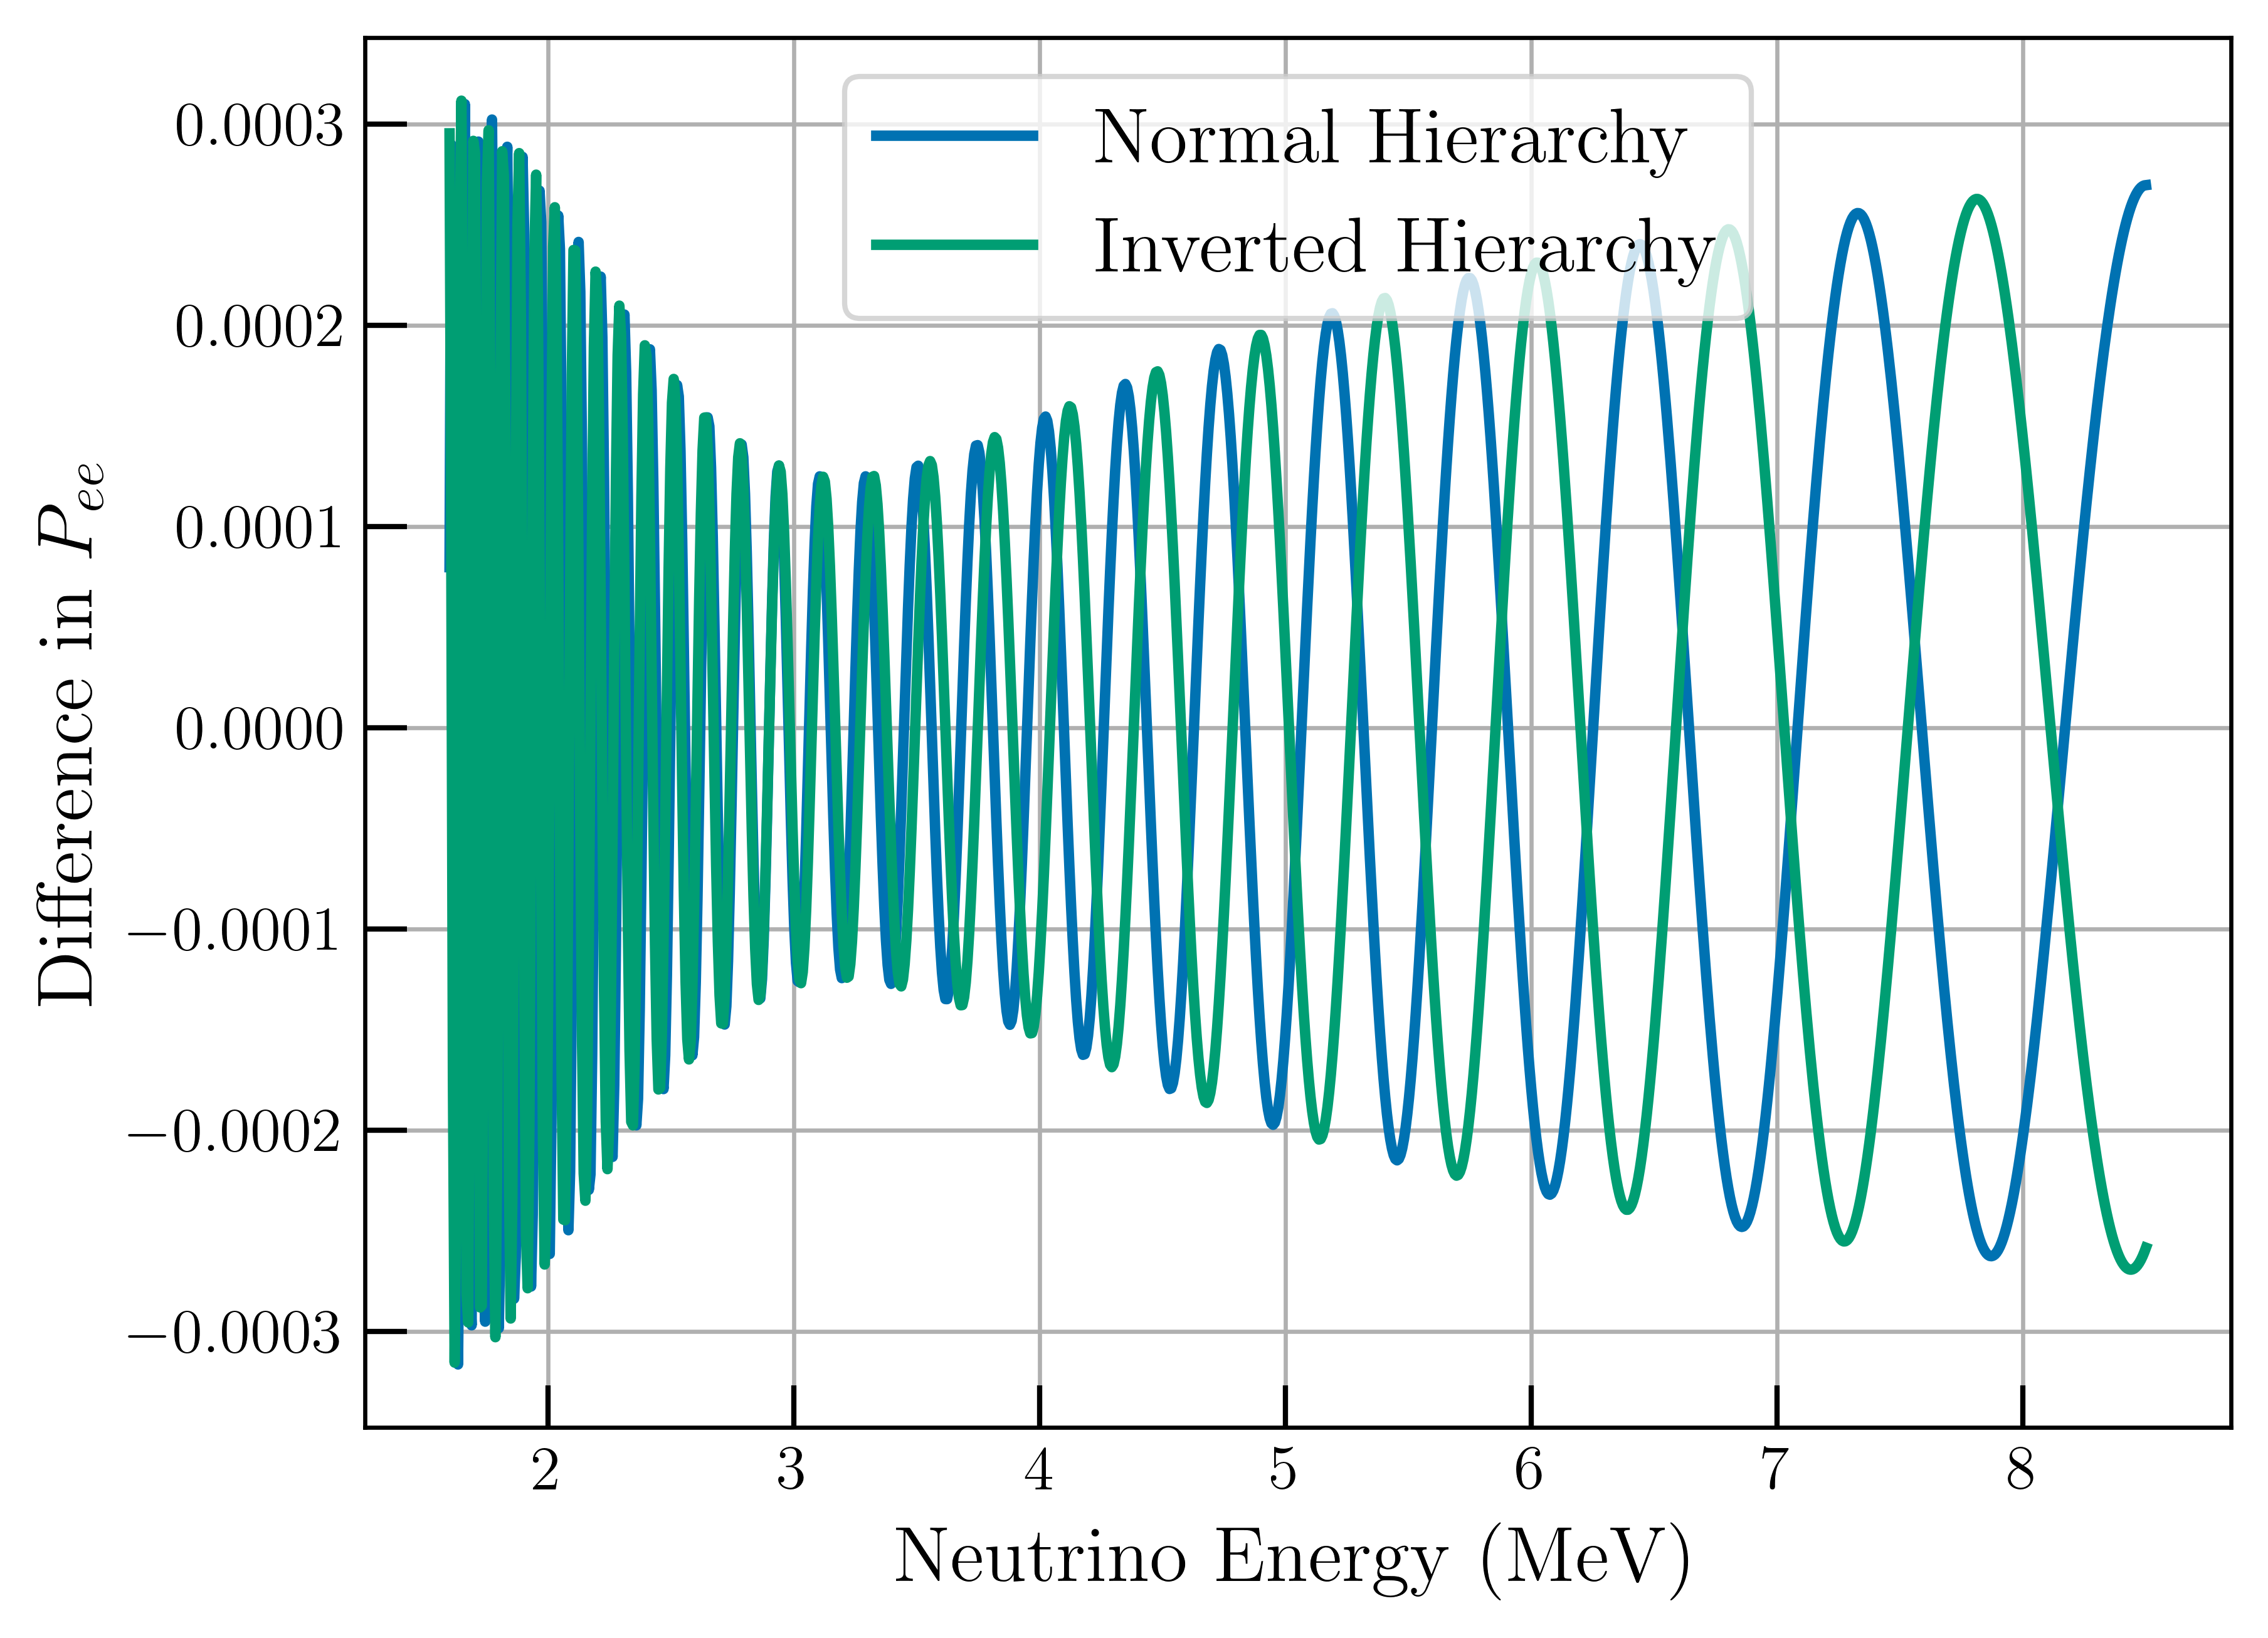

In [ ]:
from neutrino_survival import NeutrinoSurvivalDMP

ns_dmp = NeutrinoSurvivalDMP()
P_ee_normal_dmp = ns_dmp.survival_probability(energies, baseline, hierarchy="normal")
P_ee_inverted_dmp = ns_dmp.survival_probability(
    energies, baseline, hierarchy="inverted"
)

plt.plot(energies, P_ee_normal_dmp - P_ee_normal_cls, label="Normal Hierarchy")
plt.plot(energies, P_ee_inverted_dmp - P_ee_inverted_cls, label="Inverted Hierarchy")
# plt.title("Survival Probability using DMP Method vs 2-Neutrino Approximation")
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Difference in $P_{ee}$")
plt.legend()
plt.grid()
plt.savefig(
    "./plots/neutrino_survival_probability_juno_dmp_vs_twonu.pdf", bbox_inches="tight"
)

In [9]:
# Plot difference between NO/IO spectrum in vacuum and in matter
ns_dmp_vacuum = NeutrinoSurvivalDMP(
    rho=0,
    delta_m21_squared=1e-5,
    s_theta_12_squared=0.2,
    s_theta_13_squared=0.2,
    delta_m32_squared=[5e-3, -5e-3],
)
ns_vacuum = NeutrinoSurvival(
    rho=0,
    delta_m21_squared=1e-5,
    s_theta_12_squared=0.2,
    s_theta_13_squared=0.2,
    delta_m32_squared=[5e-3, -5e-3],
)
P_ee_normal_dmp_vacuum = ns_dmp_vacuum.survival_probability(
    energies, baseline, hierarchy="normal"
)
P_ee_normal_vacuum = ns_vacuum.survival_probability(
    energies, baseline, hierarchy="normal"
)
P_ee_inverted_dmp_vacuum = ns_dmp_vacuum.survival_probability(
    energies, baseline, hierarchy="inverted"
)
P_ee_inverted_vacuum = ns_vacuum.survival_probability(
    energies, baseline, hierarchy="inverted"
)
print(np.max(np.abs(P_ee_normal_dmp_vacuum - P_ee_normal_vacuum)))
print(np.max(np.abs(P_ee_inverted_dmp_vacuum - P_ee_inverted_vacuum)))

5.329070518200751e-15
3.8413716652030416e-14
